# DataJoint Workflow Miniscope

+ This notebook will describe the steps for interacting with the data ingested into `workflow-miniscope`.  

In [1]:
import os

os.chdir("..")

In [ ]:
import datajoint as dj
import matplotlib.pyplot as plt
import numpy as np

from workflow_miniscope.pipeline import subject, session, miniscope

## Workflow architecture

This workflow is assembled from 4 DataJoint elements:
+ [element-lab](https://github.com/datajoint/element-lab)
+ [element-animal](https://github.com/datajoint/element-animal)
+ [element-session](https://github.com/datajoint/element-session)
+ [element-miniscope](https://github.com/datajoint/element-miniscope)

For the architecture and detailed descriptions for each of those elements, please visit the respective links. 

Below is the diagram describing the core components of the fully assembled pipeline.


In [ ]:
dj.Diagram(miniscope) + (dj.Diagram(session.Session) + 1) - 1

## Browsing the data with DataJoint `query` and `fetch` 

+ DataJoint provides functions to query data and fetch.  For detailed tutorials, visit our [general tutorial site](https://codebook.datajoint.io/).

+ Running through the pipeline, we have ingested data of subject3 into the database.

+ Here are some highlights of the important tables.

### `Subject` and `Session` tables

In [4]:
subject.Subject()

subject,sex,subject_birth_date,subject_description
subject1,M,2021-01-01,Theo
subject6,M,2020-01-01,manuel


In [5]:
session.Session()

subject,session_datetime
subject1,2021-01-01 00:00:01
subject1,2022-04-27 12:13:01
subject6,2021-06-01 13:33:33
subject6,2021-06-02 14:04:22


+ Fetch the primary key for the session of interest which will be used later on in this notebook.

In [9]:
session_key = (
    session.Session
    & 'subject = "subject1"'
    & 'session_datetime = "2021-01-01 00:00:01"'
).fetch1("KEY")

### `Recording` and `RecordingInfo` tables

+ These tables stores the recording metadata within a particular session.

In [10]:
miniscope.Recording & session_key

subject,session_datetime,recording_id,equipment,acquisition_software,recording_directory relative to root data directory,recording_notes free-notes
subject1,2021-01-01 00:00:01,0,UCLA Miniscope,Miniscope-DAQ-V4,subject1/session1,No notes for this session.


In [11]:
miniscope.RecordingInfo & session_key

subject,session_datetime,recording_id,nchannels number of channels,nframes number of recorded frames,px_height height in pixels,px_width width in pixels,um_height height in microns,um_width width in microns,fps (Hz) frames per second,gain recording gain,"spatial_downsample e.g. 1, 2, 4, 8. 1 for no downsampling",led_power LED power used in the given recording,time_stamps time stamps of each frame,recording_datetime datetime of the recording,recording_duration (seconds) duration of the recording
subject1,2021-01-01 00:00:01,0,1,111770,600,600,nan,nan,20.0,2.0,1,5.0,=BLOB=,None,5588.5


In [13]:
miniscope.RecordingInfo.File & session_key

subject,session_datetime,recording_id,file_id,file_path relative to root data directory
subject1,2021-01-01 00:00:01,0,0,subject1/session1/0.avi


### `ProcessingParamSet`, `ProcessingTask`, `Processing`, and `Curation` tables

+ The parameters used for CaImAn are stored in `miniscope.ProcessingParamSet` under a `paramset_idx`.

+ The processing details for CaImAn are stored in `miniscope.ProcessingTask` and `miniscope.Processing` for the utilized `paramset_idx`.

+ After the motion correction and segmentation, the results may go through a curation process. 
    
    + If it did not go through curation, a copy of the `miniscope.ProcessingTask` entry is inserted into `miniscope.Curation` with the `curation_output_dir` identical to the `processing_output_dir`.

    + If it did go through a curation, a new entry will be inserted into `miniscope.Curation`, with a `curation_output_dir` specified.

    + `miniscope.Curation` supports multiple curations of an entry in `miniscope.ProcessingTask`.

In [14]:
miniscope.ProcessingParamSet()

paramset_id,processing_method,paramset_desc,param_set_hash,params dictionary of all applicable parameters
0,caiman,Calcium imaging analysis with CaImAn using default parameters,7ebfca75-7997-82ce-c46b-f0cc28f69308,=BLOB=


In [16]:
miniscope.ProcessingTask * miniscope.Processing & session_key

subject,session_datetime,recording_id,paramset_id,processing_output_dir relative to the root data directory,task_mode 'load': load existing results,"processing_time generation time of processed, segmented results",package_version
subject1,2021-01-01 00:00:01,0,0,subject1/session1/caiman,load,2022-04-27 12:13:32,


In this example workflow, `curation_output_dir` is the same as the `processing_output_dir`, as these results were not manually curated.

In [17]:
miniscope.Curation & session_key

subject,session_datetime,recording_id,paramset_id,curation_id,curation_time time of generation of these curated results,"curation_output_dir output directory of the curated results,",manual_curation has manual curation been performed?,curation_note
subject1,2021-01-01 00:00:01,0,0,0,2022-04-30 12:22:15,subject1/session1/caiman,0,


### `MotionCorrection` table

+ After processing and curation, results are passed to the `miniscope.MotionCorrection` and `miniscope.Segmentation` tables.

+ For the example data, the raw data is corrected with rigid and non-rigid motion correction which is stored in `miniscope.MotionCorrection.RigidMotionCorrection` and `miniscope.MotionCorrection.NonRigidMotionCorrection`, respectively. 

+ Lets first query the information for one curation.

In [18]:
curation_key = (miniscope.Curation & session_key & "curation_id=0").fetch1("KEY")

In [19]:
curation_key

{'subject': 'subject1',
 'session_datetime': datetime.datetime(2021, 1, 1, 0, 0, 1),
 'recording_id': 0,
 'paramset_id': 0,
 'curation_id': 0}

In [20]:
miniscope.MotionCorrection.RigidMotionCorrection & curation_key

subject,session_datetime,recording_id,paramset_id,curation_id,outlier_frames mask with true for frames with outlier shifts,y_shifts (pixels) y motion correction shifts,x_shifts (pixels) x motion correction shifts,y_std (pixels) standard deviation of,x_std (pixels) standard deviation of
subject1,2021-01-01 00:00:01,0,0,0,=BLOB=,=BLOB=,=BLOB=,0.0561964,0.0570838


In [ ]:
miniscope.MotionCorrection.NonRigidMotionCorrection & curation_key

+ For non-rigid motion correction, the details for the individual blocks are stored in `imaging.MotionCorrection.Block`.

In [ ]:
miniscope.MotionCorrection.Block & curation_key & "block_id=0"

+ Summary images are stored in `imaging.MotionCorrection.Summary`

    + Reference image - image used as an alignment template

    + Average image - mean of registered frames

    + Correlation image - correlation map (computed during region of interest \[ROI\] detection)

    + Maximum projection image - max of registered frames

In [24]:
miniscope.MotionCorrection.Summary & curation_key

subject,session_datetime,recording_id,paramset_id,curation_id,ref_image image used as alignment template,average_image mean of registered frames,correlation_image correlation map,max_proj_image max of registered frames
subject1,2021-01-01 00:00:01,0,0,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=


+ Lets fetch the `average_image` and plot it.

In [31]:
average_image = (
    (miniscope.MotionCorrection.Summary & curation_key)
    .fetch1("average_image")
    .reshape(600, 600, 1)
)

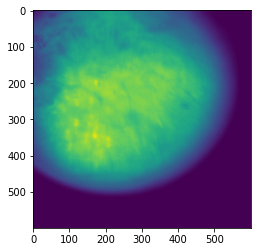

In [32]:
plt.imshow(average_image);

### `Segmentation` table

+ Lets fetch and plot a mask stored in the `miniscope.Segmentation.Mask` table for one `curation_id`.

+ Each mask can be associated with a field by the attribute `mask_center_z`.  For example, masks with `mask_center_z=0` are in the field identified with `field_idx=0` in `miniscope.RecordingInfo`.

In [29]:
mask_xpix, mask_ypix = (
    miniscope.Segmentation.Mask * miniscope.MaskClassification.MaskType
    & curation_key
    & "mask_npix > 130"
).fetch("mask_xpix", "mask_ypix")

In [33]:
mask_image = np.zeros(np.shape(average_image), dtype=bool)
for xpix, ypix in zip(mask_xpix, mask_ypix):
    mask_image[ypix, xpix] = True

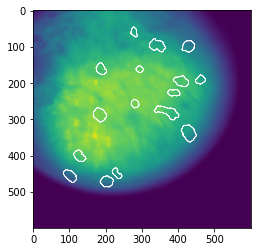

In [38]:
plt.imshow(average_image)
plt.contour(mask_image.reshape(600, 600), colors="white", linewidths=0.5);

### `MaskClassification` table

+ This table provides the `mask_type` and `confidence` for the mask classification.

In [41]:
miniscope.MaskClassification.MaskType & curation_key & "mask_id=13"

subject,session_datetime,recording_id,paramset_id,curation_id,mask_classification_method,mask_id,mask_type,confidence
subject1,2021-01-01 00:00:01,0,0,0,caiman_default_classifier,13,soma,nan


### `Fluorescence` and `Activity` tables

+ Lets fetch and plot the fluorescence and activity traces for one mask.

In [42]:
query_cells = (
    miniscope.Segmentation.Mask * miniscope.MaskClassification.MaskType
    & curation_key
    & "mask_npix > 130"
).proj()

In [44]:
fluorescence_traces = (miniscope.Fluorescence.Trace & query_cells).fetch(
    "fluorescence", order_by="mask_id"
)

activity_traces = (miniscope.Activity.Trace & query_cells).fetch(
    "activity_trace", order_by="mask_id"
)

sampling_rate = (miniscope.RecordingInfo & curation_key).fetch1("fps")  # [Hz]

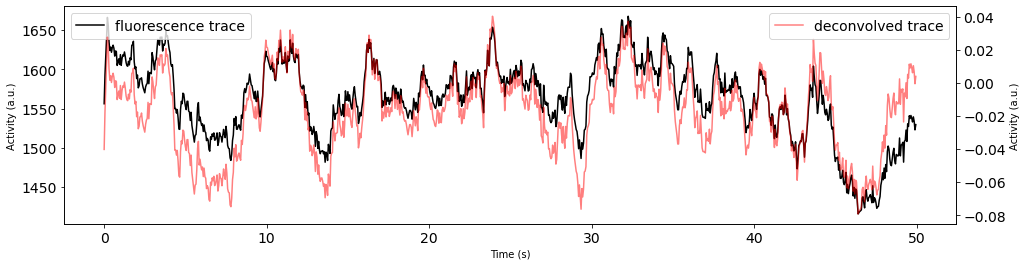

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax2 = ax.twinx()

for f, a in zip(fluorescence_traces, activity_traces):
    ax.plot(np.r_[: f.size] * 1 / sampling_rate, f, "k", label="fluorescence trace")
    ax2.plot(
        np.r_[: a.size] * 1 / sampling_rate,
        a,
        "r",
        alpha=0.5,
        label="deconvolved trace",
    )

    break

ax.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)

ax.legend(loc="upper left", prop={"size": 14})
ax2.legend(loc="upper right", prop={"size": 14})

ax.set_xlabel("Time (s)")
ax.set_ylabel("Activity (a.u.)")
ax2.set_ylabel("Activity (a.u.)");

## Summary and Next Step

+ This notebook highlights the major tables in the workflow and visualize some of the ingested results. 

+ The next notebook [06-drop](06-drop-optional.ipynb) shows how to drop schemas and tables if needed.